<a href="https://colab.research.google.com/github/kslote1/Data-Driven-Dynamics/blob/main/chapter_one/eigenfaces.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_lfw_people
import numpy as np
from sklearn.svm import SVC


lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4)

# introspect the images arrays to find the shapes (for plotting)
n_samples, h, w = lfw_people.images.shape

# for machine learning we use the 2 data directly (as relative pixel
# positions info is ignored by this model)
X = lfw_people.data
n_features = X.shape[1]

# the label to predict is the id of the person
y = lfw_people.target
target_names = lfw_people.target_names
n_classes = target_names.shape[0]

print("Total dataset size:")
print("n_samples: %d" % n_samples)
print("n_features: %d" % n_features)
print("n_classes: %d" % n_classes)
#print(print(lfw_people['DESCR']))

Total dataset size:
n_samples: 1288
n_features: 1850
n_classes: 7


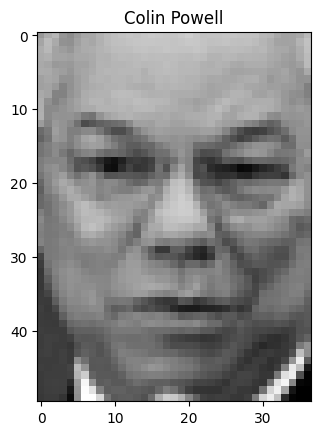

In [15]:
plt.imshow(lfw_people.images[40], cmap=plt.cm.gray)
plt.title(target_names[y[40]])
plt.show()

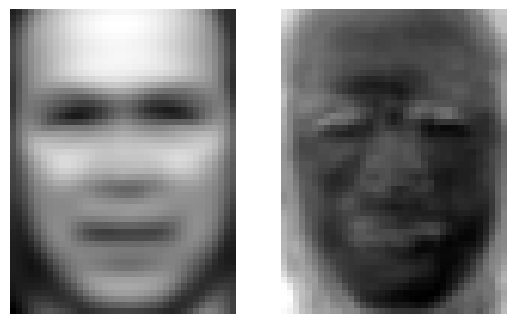

In [109]:
# Reshape images into a tall-skinny data matrix. This comes precomputed.
X = lfw_people.data.T

m = lfw_people.images[40].shape[0]
n = lfw_people.images[40].shape[1]

# Subtract the mean from each column
X_mean = np.mean(X, axis=1)
X = X - np.tile(X_mean, (X.shape[1], 1)).T

# Compute the SVD
U, S, VT = np.linalg.svd(X, full_matrices=0)

# Refactored code
fig, (ax1, ax2) = plt.subplots(1, 2)

# Displaying the average face
ax1.imshow(np.reshape(X_mean, (m, n)), cmap='gray')
ax1.axis('off')

# Displaying the first eigenface
ax2.imshow(np.reshape(U[:, 0], (m, n)), cmap='gray')
ax2.axis('off')

plt.show()

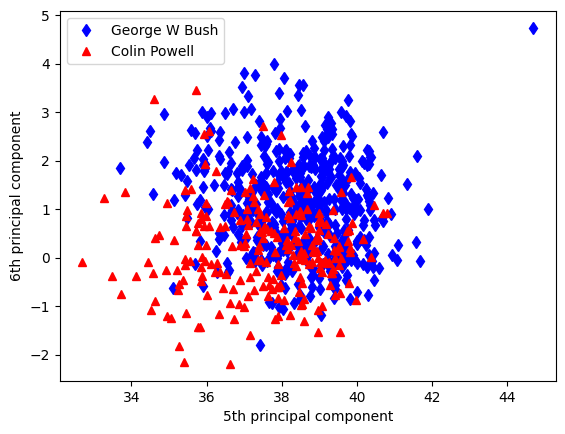

In [149]:
# Indices for George Bush and Colin Powell
bush_name = np.where(target_names == 'George W Bush')[0][0]
powell_name = np.where(target_names == 'Colin Powell')[0][0]

# Find indices where target names match George Bush and Colin Powell
bush_indices = [i for i, name in enumerate(lfw_people.target) if name == bush_name]
powell_indices = [i for i, name in enumerate(lfw_people.target) if name == powell_name]

# Extracting columns corresponding to George Bush and Colin Powell
bush_images = X[:, bush_indices]
powell_images = X[:, powell_indices]

# Subtract the mean face
# Correct tiling for subtracting the mean
X = X - np.tile(X_mean, (X.shape[1], 1)).T
bush_images -= np.tile(X_mean, (bush_images.shape[1], 1)).T
powell_images -= np.tile(X_mean, (powell_images.shape[1], 1)).T

pca_modes = [3, 5]
# Projection
pca_bush = U[:, pca_modes].T @ bush_images
pca_powell = U[:, pca_modes].T @ powell_images

# Plotting
plt.plot(pca_bush[0, :], pca_bush[1, :], 'd', color='blue', label='George W Bush')
plt.plot(pca_powell[0, :], pca_powell[1, :], '^', color='red', label='Colin Powell')

plt.xlabel('5th principal component')
plt.ylabel('6th principal component')
plt.legend()
plt.show()

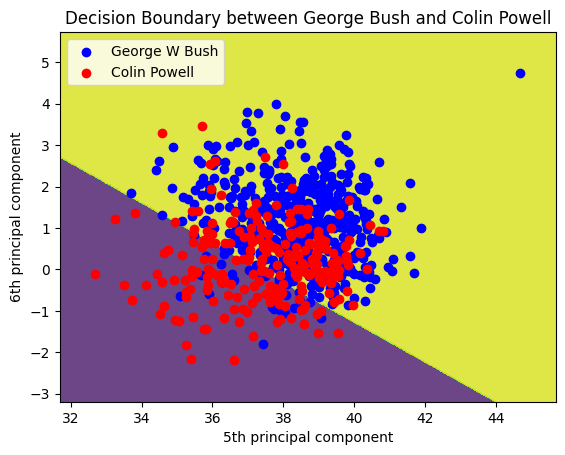

In [150]:
# Extract the 5th and 6th principal components
PC_5 = U[:, 3]
PC_6 = U[:, 5]

# Project the data onto these components
X_proj = np.dot(X.T, np.vstack((PC_5, PC_6)).T)

# Filter data for George Bush and Colin Powell
bush_idx = np.where(target_names == 'George W Bush')[0]
powell_idx = np.where(target_names == 'Colin Powell')[0]

# Extract indices of images for both individuals
indices_bush = [i for i, x in enumerate(y) if x in bush_idx]
indices_powell = [i for i, x in enumerate(y) if x in powell_idx]
indices = indices_bush + indices_powell

# Selecting the projected data for Bush and Powell
X_selected = X_proj[indices]
y_selected = y[indices]

# Train a linear SVM classifier
clf = SVC(kernel='linear')
clf.fit(X_selected, y_selected)

# Create a grid to plot decision boundaries
h = .02  # step size in the mesh
x_min, x_max = X_selected[:, 0].min() - 1, X_selected[:, 0].max() + 1
y_min, y_max = X_selected[:, 1].min() - 1, X_selected[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Plot decision boundary
Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Plot the 5th and 6th components for both individuals
plt.contourf(xx, yy, Z, alpha=0.8)
plt.scatter(X_selected[y_selected == bush_idx[0], 0], X_selected[y_selected == bush_idx[0], 1], c='blue', label='George W Bush')
plt.scatter(X_selected[y_selected == powell_idx[0], 0], X_selected[y_selected == powell_idx[0], 1], c='red', label='Colin Powell')

plt.xlabel('5th principal component')
plt.ylabel('6th principal component')
plt.title('Decision Boundary between George Bush and Colin Powell')
plt.legend()

plt.show()

# Extra

## Find the optimal principal components to draw the decision boundary.

In [152]:
from sklearn.metrics import pairwise_distances

best_separation = 0
best_pca_modes = None

for i in range(1, 50):
    for j in range(i+1, 50):
        pca_modes = [i, j]

        # Projection
        pca_bush = U[:, pca_modes].T @ bush_images
        pca_powell = U[:, pca_modes].T @ powell_images

        # Calculate centroids
        centroid_bush = np.mean(pca_bush, axis=1)
        centroid_powell = np.mean(pca_powell, axis=1)

        # Measure separation (Euclidean distance between centroids)
        separation = np.linalg.norm(centroid_bush - centroid_powell)

        if separation > best_separation:
            best_separation = separation
            best_pca_modes = pca_modes

print(f"Best PCA modes for separation: {best_pca_modes}, with separation score: {best_separation}")

Best PCA modes for separation: [3, 5], with separation score: 1.2831865549087524
